# 1. Data: Detecting Anomalies in Wafer Manufacturing
- 데이터 description <br>
    - 반도체 생산 공정으로부터 수집된 데이터 셋으로 총 1558개의 센서 값을 통해 반도체 생산 공정의 정상/비정상 상황을 검출하는 것을 목적으로 함 <br><br>
- 변수 설명
    - 독립 변수 (1558개): Feature1, Feature2, Feature3,... Feature1558 <br><br>

In [ ]:
!git clone https://github.com/kc9410/Model_Evaluation.git

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Step1. 데이터 불러오기

In [158]:
# 데이터 불러오기
data = pd.read_csv('/content/Model_Evaluation/data/Wafer.csv')
data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Class 개수 확인
print("정상  :",np.sum(data["Class"]==0))
print("비정상:",np.sum(data["Class"]==1))

정상  : 1620
비정상: 143


### Step2. 데이터 Split

In [4]:
normal = data[data["Class"]==0]
abnormal = data[data["Class"]==1]
X_train = normal.iloc[:1000,:-1]
y_train = normal.iloc[:1000,-1]
X_test = pd.concat([normal.iloc[1000:,:-1],abnormal.iloc[:,:-1]])
y_test = pd.concat([normal.iloc[1000:,-1],abnormal.iloc[:,-1]])

In [5]:
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (1000, 1558)
Test data shape: (763, 1558)


### Step3. 데이터 정규화

In [6]:
# train 데이터를 기반으로 train/test 데이터에 대하여 standard scaling 적용 (평균 0, 분산 1) 
scaler = StandardScaler()
scaler = scaler.fit(X_train)

In [7]:
X_train_scaled = pd.DataFrame(scaler.transform(X_train), 
                              columns=X_train.columns, 
                              index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                             columns=X_test.columns, 
                             index=X_test.index)

# 2-1. 모델 학습: Local Outlier Factor

### Local Outlier Factor (LOF)
>이상치 스코어를 산출할 떄 주변부 데이터의 밀도를 고려하고자 함

<img src="https://i.imgur.com/flXG1jT.jpg" width="450">

In [8]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

### Step 1. Train 데이터 기반 모델 적합

- LocalOutlierFactor 설명
    - n_neighbors: neighbors 개수. 디폴트 20
    - algorithm: nearest neighbors 계산 방법 ('auto', 'ball_tree', 'kd_tree', 'brute'}. 디폴트 'auto'
    - metric: distance 계산 방법. 디폴트 'minkowski'
    - novelty: True (for novelty detection - no oulier in train data), False (for outlier detection - ouliers in train data). 디폴트 False

In [9]:
# LOF 모델 적합
lof_model = LocalOutlierFactor(n_neighbors=200, novelty=True)
lof_model.fit(X_train_scaled)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=200, novelty=True, p=2)

### Step 2. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출

In [10]:
# train/test 데이터의 LOF score 도출
lof_train = - 1.0 * lof_model.score_samples(X_train_scaled)
lof_test = - 1.0 * lof_model.score_samples(X_test_scaled)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Data')

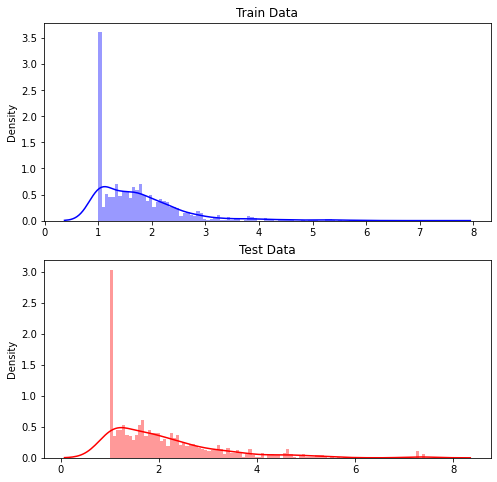

In [11]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.distplot(lof_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(lof_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

# 2-2. 모델 학습: Isolation Forest

### Isolation Forest
>하나의 객체를 고립시키는 의사결정나무를 생성하여 이상치를 탐지하고자 함 <br>
>정상 데이터는 고립시키는데 많은 분기가 필요하지만, 이상치 데이터라면 상대적으로 적은 분기만으로 고립이 가능함

<img src="https://i.imgur.com/VVbACBB.jpg" width="700">

### Step 1. Train 데이터 기반 모델 적합

- IsolationForest 설명
    - n_estimators: 트리 개수. 디폴트 100
    - bootstrap: 데이터의 중복 사용 여부. 디폴트 False
    - max_samples: 데이터 샘플 중 선택할 샘플의 수 혹은 비율 ('auto': max_samples=min(256, n_samples)) . 디폴트 'auto'

In [12]:
from sklearn.ensemble import IsolationForest

In [13]:
if_model = IsolationForest(n_estimators=5000,bootstrap=True,random_state=0)
if_model.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=True, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=5000,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

### Step 2. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출

In [14]:
# train 데이터의 Anomaly score 도출
if_train = - 1.0 * if_model.score_samples(X_train)
if_test = - 1.0 * if_model.score_samples(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Data')

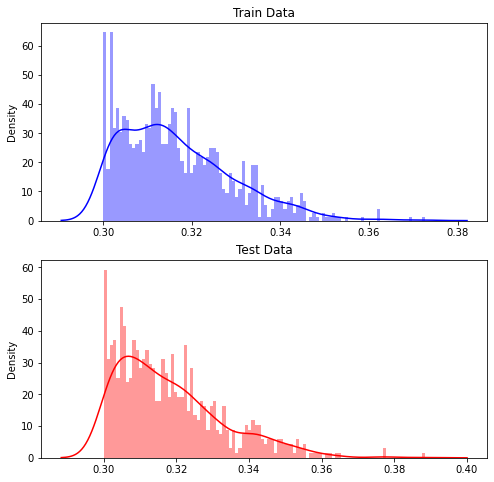

In [15]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.distplot(if_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(if_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

# 3. 모델 평가

### Step 1. Accuracy 기반 Anomaly Detection 모델 Best Treshold 설정

- Anomaly 데이터 셋은 매우 드물게 발생한다는 특성을 가짐
- 따라서 Accuracy 기반의 Treshold는 해당 모델을 anomaly detection 성능을 제대로 대변할 수 없음

In [16]:
# Accuracy 기반 Best Threshold Search
def search_best_acc_threshold(score, y_true, num_step):
    best_acc = 0
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score
        
        acc = np.sum(y_true==y_pred)/len(y_true)
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best Acc Score:', round(best_acc, 4))
    return best_threshold

In [17]:
print("LOF_Result")
lof_best_acc_threshold = search_best_acc_threshold(lof_test, y_test, num_step=100)
print("IF_Result")
if_best_acc_threshold = search_best_acc_threshold(if_test, y_test, num_step=100)

LOF_Result
Best threshold:  4.0486
Best Acc Score: 0.8296
IF_Result
Best threshold:  0.3455
Best Acc Score: 0.8283


In [18]:
lof_pred_label = lof_best_acc_threshold<lof_test
if_pred_label = if_best_acc_threshold<if_test

- Confusion Matrix를 통해 Accuracy 기반의 Threshold의 성능을 평가할 수 있음
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FqA1HM%2Fbtq88KWjCU0%2FOjvkpKyJxjscqcUi4YhxJ1%2Fimg.png" width="500">


- False Rejection Rate(FRR): FP/(FP+TN)
    - 원래는 정상이나 이상치 탐지 모델에 의해 이상치로 잘못 판별된(refected) 비율
- False Acceptance Rate(FRR): FN/(TP+FN)
    - 원래는 이상치로 탐지가 되어야 하지만 이상치 탐지 모델에 의해 정상으로 잘못 판별된(accepted) 비율

In [19]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve

In [20]:
lof_cm = confusion_matrix(y_test,lof_pred_label)
print(lof_cm)
print("FRR:",lof_cm[0,1]/(lof_cm[0,0]+lof_cm[0,1]))
print("FAR:",lof_cm[1,0]/(lof_cm[1,0]+lof_cm[1,1]))

[[599  21]
 [109  34]]
FRR: 0.03387096774193549
FAR: 0.7622377622377622


In [21]:
if_cm = confusion_matrix(y_test,if_pred_label)
print(if_cm)
print("FRR:",if_cm[0,1]/(if_cm[0,0]+if_cm[0,1]))
print("FAR:",if_cm[1,0]/(if_cm[1,0]+if_cm[1,1]))

[[603  17]
 [114  29]]
FRR: 0.027419354838709678
FAR: 0.7972027972027972


### Step 2. EER 기반 Anomaly Detection 모델 Best Treshold 설정

- FRR과 FAR을 동시에 고려할 수 있는 지표를 통해 Best Treshold를 선정해야 함
- EER은 FRR과 FAR이 같아지는 지점을 의미하므로 Best Threshold를 선정하는 기준으로 사용하기에 적합함

In [22]:
def search_EER_threshold(score, y_true, num_step):
    FRR_list = []
    FAR_list = []
    best_EER = 100
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score
        cm = confusion_matrix(y_true,y_pred)
        FRR = cm[0,1]/(cm[0,0]+cm[0,1])
        FAR = cm[1,0]/(cm[1,0]+cm[1,1])
        
        FRR_list.append(FRR)
        FAR_list.append(FAR)
        if abs(FAR-FRR)<best_EER:
            best_EER = abs(FAR-FRR)
            best_threshold = threshold
    print('Best threshold: ', round(best_threshold, 4))
    return best_threshold, FRR_list, FAR_list

In [23]:
print("LOF_Result")
lof_eer_threshold, lof_FRR, lof_FAR = search_EER_threshold(lof_test, y_test, num_step=100)
print("IF_Result")
if_eer_threshold, if_FRR, if_FAR = search_EER_threshold(if_test, y_test, num_step=100)

LOF_Result
Best threshold:  2.1011
IF_Result
Best threshold:  0.3179


In [24]:
lof_pred_label = lof_eer_threshold<lof_test
if_pred_label = if_eer_threshold<if_test

In [25]:
lof_cm = confusion_matrix(y_test,lof_pred_label)
print(lof_cm)
print("FRR:",lof_cm[0,1]/(lof_cm[0,0]+lof_cm[0,1]))
print("FAR:",lof_cm[1,0]/(lof_cm[1,0]+lof_cm[1,1]))

[[429 191]
 [ 45  98]]
FRR: 0.30806451612903224
FAR: 0.3146853146853147


In [26]:
if_cm = confusion_matrix(y_test,if_pred_label)
print(if_cm)
print("FRR:",if_cm[0,1]/(if_cm[0,0]+if_cm[0,1]))
print("FAR:",if_cm[1,0]/(if_cm[1,0]+if_cm[1,1]))

[[384 236]
 [ 54  89]]
FRR: 0.38064516129032255
FAR: 0.3776223776223776


- Integrated Error
    - Integrated Error=1-AUROC로 FAR과 FRR으로 그려지는 plot의 밑넓이로 구할 수 있으며, AUROC와 마찬가지로 Anomaly Detection 모델에 대한 성능 평가 지표로 활용됨
    - AUROC와 반대로 값이 낮을수록 해당 모델의 성능이 높다고 판단할 수 있음

Text(0, 0.5, 'FAR')

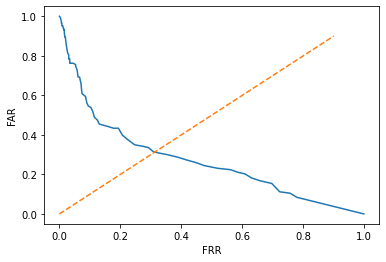

In [27]:
t = np.arange(0,1,0.1)

plt.plot(lof_FRR,lof_FAR)
plt.plot(t,t,'--')
plt.xlabel('FRR')
plt.ylabel('FAR')

In [28]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(y_test, lof_test, average='macro')
IE = 1-roc_score
print("LOF Integrated Error:",IE)

LOF Integrated Error: 0.2698962327994585


Text(0, 0.5, 'FAR')

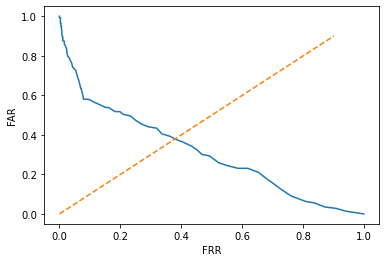

In [29]:
t = np.arange(0,1,0.1)

plt.plot(if_FRR,if_FAR)
plt.plot(t,t,'--')
plt.xlabel('FRR')
plt.ylabel('FAR')

In [30]:
roc_score = roc_auc_score(y_test, if_test, average='macro')
IE = 1-roc_score
print("IF Integrated Error:",IE)

IF Integrated Error: 0.3081660275208662
